# Single-lineage Hierarchical Model Report

## Setup

### Imports

In [ ]:
import logging
from math import ceil
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

In [ ]:
from speclet.analysis.arviz_analysis import describe_mcmc, extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.data_processing.vectors import squish_array
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.posterior_data_manager import PosteriorDataManager
from speclet.project_configuration import arviz_config
from speclet.project_enums import ModelFitMethod

In [ ]:
set_console_handler_level(logging.INFO)
%config InlineBackend.figure_format = "retina"
arviz_config()

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

### Papermill parameters

In [ ]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD = ""
ROOT_CACHE_DIR = ""

In [ ]:
_fit_method = ModelFitMethod(FIT_METHOD)
postman = PosteriorDataManager(
    name=MODEL_NAME,
    fit_method=_fit_method,
    config_path=project_root() / Path(CONFIG_PATH),
    posterior_dir=project_root() / Path(ROOT_CACHE_DIR),
)

In [ ]:
assert isinstance(postman.bayes_model, LineageHierNegBinomModel)

In [ ]:
print(postman.read_description())

In [ ]:
postman.load_all()

## Fit diagnostics

In [ ]:
def _plot_rhat_boxplots(pm: PosteriorDataManager) -> None:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(data=pm.posterior_summary, x="var_name", y="r_hat", ax=ax)
    ax.tick_params("x", rotation=90)
    ax.set_ylabel(r"$\widehat{R}$")
    ax.set_ylim(0.999, None)
    plt.show()


def _plot_ess_hist(pm: PosteriorDataManager) -> None:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharex=False, sharey=False, figsize=(8, 4)
    )
    sns.histplot(data=pm.posterior_summary, x="ess_bulk", ax=axes[0])
    axes[0].set_title("ESS (bulk)")
    sns.histplot(data=pm.posterior_summary, x="ess_tail", ax=axes[1])
    axes[1].set_title("ESS (tail)")
    for ax in axes.flatten():
        ax.set_xlim(0, None)
    fig.tight_layout()
    plt.show()

In [ ]:
if postman.fit_method in {ModelFitMethod.PYMC_NUMPYRO, ModelFitMethod.PYMC_MCMC}:
    _plot_rhat_boxplots(postman)
    _plot_ess_hist(postman)
    print("=" * 60)
    describe_mcmc(postman.trace)

## Posterior analysis

In [ ]:
ignore_vars = ["mu_a", "a", "b", "d", "f", "h", "k", "m"]
ignore_vars = [f"~^{v}$" for v in ignore_vars]
ignore_vars += postman.bayes_model.vars_regex(postman.fit_method)
az.plot_trace(postman.trace, var_names=ignore_vars, filter_vars="regex")
plt.tight_layout()
plt.show()

In [ ]:
sigma_vars = list(
    {v for v in postman.posterior_summary["var_name"].unique() if "sigma" in v}
)
sigma_vars.sort()

axes = az.plot_forest(
    postman.trace,
    var_names=sigma_vars,
    combined=True,
    figsize=(6, len(sigma_vars) * 0.6),
)
axes[0].axvline(0, color="k", lw=0.8, zorder=1)
plt.tight_layout()
plt.show()

In [ ]:
sgrna_to_gene_map = (
    postman.data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [ ]:
cancer_genes = postman.trace.posterior.coords["cancer_gene"].values.tolist()
cancer_genes

In [ ]:
example_genes = ["KRAS", "BRAF", "CTNNB1", "TP53", "PTEN", "STK11", "MDM2"]
for example_gene in example_genes:
    display(Markdown(f"🧬 **target gene: *{example_gene}***"))
    example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
        "sgrna"
    ].tolist()
    axes = az.plot_forest(
        postman.trace,
        var_names=[
            "mu_mu_a",
            "mu_a",
            "a",
            "mu_b",
            "b",
            "d",
            "f",
            "h",
        ],
        coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
        combined=True,
        figsize=(6, 4 + 0.3 * len(cancer_genes)),
    )
    axes[0].axvline(0, color="k", lw=0.8, zorder=1)
    plt.show()

In [ ]:
h_post_summary = (
    postman.posterior_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)

_, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene", ax=ax)
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

h_post_df = (
    postman.posterior_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["target_gene", "cancer_gene"],
        col="parameter",
    )
    .pivot_wider("target_gene", names_from="cancer_gene", values_from="mean")
    .set_index("target_gene")
)

h_gene_var = h_post_df.values.var(axis=1)
idx = h_gene_var >= np.quantile(h_gene_var, q=0.8)
h_post_df_topvar = h_post_df.loc[idx, :]

width = max(2, len(cancer_genes) * 0.5)
sns.clustermap(
    h_post_df_topvar,
    cmap="seismic",
    center=0,
    figsize=(width, 12),
    col_cluster=len(cancer_genes) > 1,
    cbar_pos=(1, 0.4, 0.05, 0.2),
    dendrogram_ratio=(0.1, 0.1 if len(cancer_genes) > 1 else 0),
)
plt.show()

In [ ]:
tp53_muts = (
    postman.valid_data.query("hugo_symbol == 'TP53'")[["depmap_id", "is_mutated"]]
    .copy()
    .drop_duplicates()
    .rename(columns={"is_mutated": "TP53 mut."})
    .reset_index(drop=True)
)

cell_line_vars = ["mu_k", "mu_m"]
cell_line_effects = (
    az.summary(postman.trace, var_names=cell_line_vars, kind="stats")
    .pipe(extract_coords_param_names, names=["depmap_id"])
    .assign(var_name=lambda d: [x.split("[")[0] for x in d.index.values])
    .pivot_wider(
        index="depmap_id",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    .merge(tp53_muts, on="depmap_id")
)

fig, ax = plt.subplots(figsize=(6, 5))

ax.axhline(0, color="k", zorder=1)
ax.axvline(0, color="k", zorder=1)

ax.vlines(
    x=cell_line_effects["mean_mu_k"],
    ymin=cell_line_effects["hdi_5.5%_mu_m"],
    ymax=cell_line_effects["hdi_94.5%_mu_m"],
    alpha=0.5,
    color="gray",
)
ax.hlines(
    y=cell_line_effects["mean_mu_m"],
    xmin=cell_line_effects["hdi_5.5%_mu_k"],
    xmax=cell_line_effects["hdi_94.5%_mu_k"],
    alpha=0.5,
    color="gray",
)
mut_pal = {True: "tab:red", False: "tab:blue"}
sns.scatterplot(
    data=cell_line_effects,
    x="mean_mu_k",
    y="mean_mu_m",
    hue="TP53 mut.",
    palette=mut_pal,
    ax=ax,
    zorder=10,
)

sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()
plt.show()

In [ ]:
cell_chromosome_map = (
    postman.valid_data[["depmap_id", "sgrna_target_chr", "cell_chrom"]]
    .drop_duplicates()
    .sort_values("cell_chrom")
    .reset_index(drop=True)
)
chromosome_effect_post = (
    az.summary(postman.trace, var_names=["k", "m"], kind="stats")
    .pipe(extract_coords_param_names, names="cell_chrom")
    .assign(var_name=lambda d: [p[0] for p in d.index.values])
    .merge(cell_chromosome_map, on="cell_chrom")
)

ncells = chromosome_effect_post["depmap_id"].nunique()
ncols = 3
nrows = ceil(ncells / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, nrows * 3))
for ax, (cell, data_c) in zip(
    axes.flatten(), chromosome_effect_post.groupby("depmap_id")
):
    plot_df = data_c.pivot_wider(
        index="sgrna_target_chr",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    cell_eff = (
        cell_line_effects.copy().query(f"depmap_id == '{cell}'").reset_index(drop=True)
    )

    ax.axhline(0, color="k", zorder=1)
    ax.axvline(0, color="k", zorder=1)

    ax.vlines(
        x=plot_df["mean_k"],
        ymin=plot_df["hdi_5.5%_m"],
        ymax=plot_df["hdi_94.5%_m"],
        alpha=0.5,
        zorder=5,
    )
    ax.hlines(
        y=plot_df["mean_m"],
        xmin=plot_df["hdi_5.5%_k"],
        xmax=plot_df["hdi_94.5%_k"],
        alpha=0.5,
        zorder=5,
    )
    sns.scatterplot(data=plot_df, x="mean_k", y="mean_m", ax=ax, zorder=10)

    ax.vlines(
        x=cell_eff["mean_mu_k"],
        ymin=cell_eff["hdi_5.5%_mu_m"],
        ymax=cell_eff["hdi_94.5%_mu_m"],
        alpha=0.8,
        zorder=15,
        color="red",
    )
    ax.hlines(
        y=cell_eff["mean_mu_m"],
        xmin=cell_eff["hdi_5.5%_mu_k"],
        xmax=cell_eff["hdi_94.5%_mu_k"],
        alpha=0.8,
        zorder=15,
        color="red",
    )
    sns.scatterplot(
        data=cell_eff, x="mean_mu_k", y="mean_mu_m", ax=ax, zorder=20, color="red"
    )
    ax.set_title(cell)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

for ax in axes[-1, :]:
    ax.set_xlabel("$k$")
for ax in axes[:, 0]:
    ax.set_ylabel("$m$")
for ax in axes.flatten()[ncells:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

In [ ]:
for v, data_v in chromosome_effect_post.groupby("var_name"):
    df = (
        data_v.copy()
        .reset_index(drop=True)
        .pivot_wider(
            index="depmap_id", names_from="sgrna_target_chr", values_from="mean"
        )
        .set_index("depmap_id")
    )
    height = max(2.5, df.shape[0] * 0.15)
    cg = sns.clustermap(
        df,
        cmap="seismic",
        figsize=(7, height),
        cbar_pos=(1, 0.4, 0.05, 0.2),
        dendrogram_ratio=(0.1, 0.1),
        center=0,
    )
    cg.ax_col_dendrogram.set_title(f"variable: ${v}$")
    plt.show()

In [47]:
chrom_target_positions = (
    postman.valid_data.copy()[
        [
            "hugo_symbol",
            "sgrna",
            "sgrna_target_chr",
            "sgrna_target_pos",
            "copy_number",
            "cn_gene",
            "depmap_id",
        ]
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)

d_post = (
    postman.posterior_summary.query("var_name == 'd'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .merge(chrom_target_positions, on="hugo_symbol", validate="one_to_many")
    .assign(cn_effect=lambda d: d["mean"] * d["cn_gene"])
)

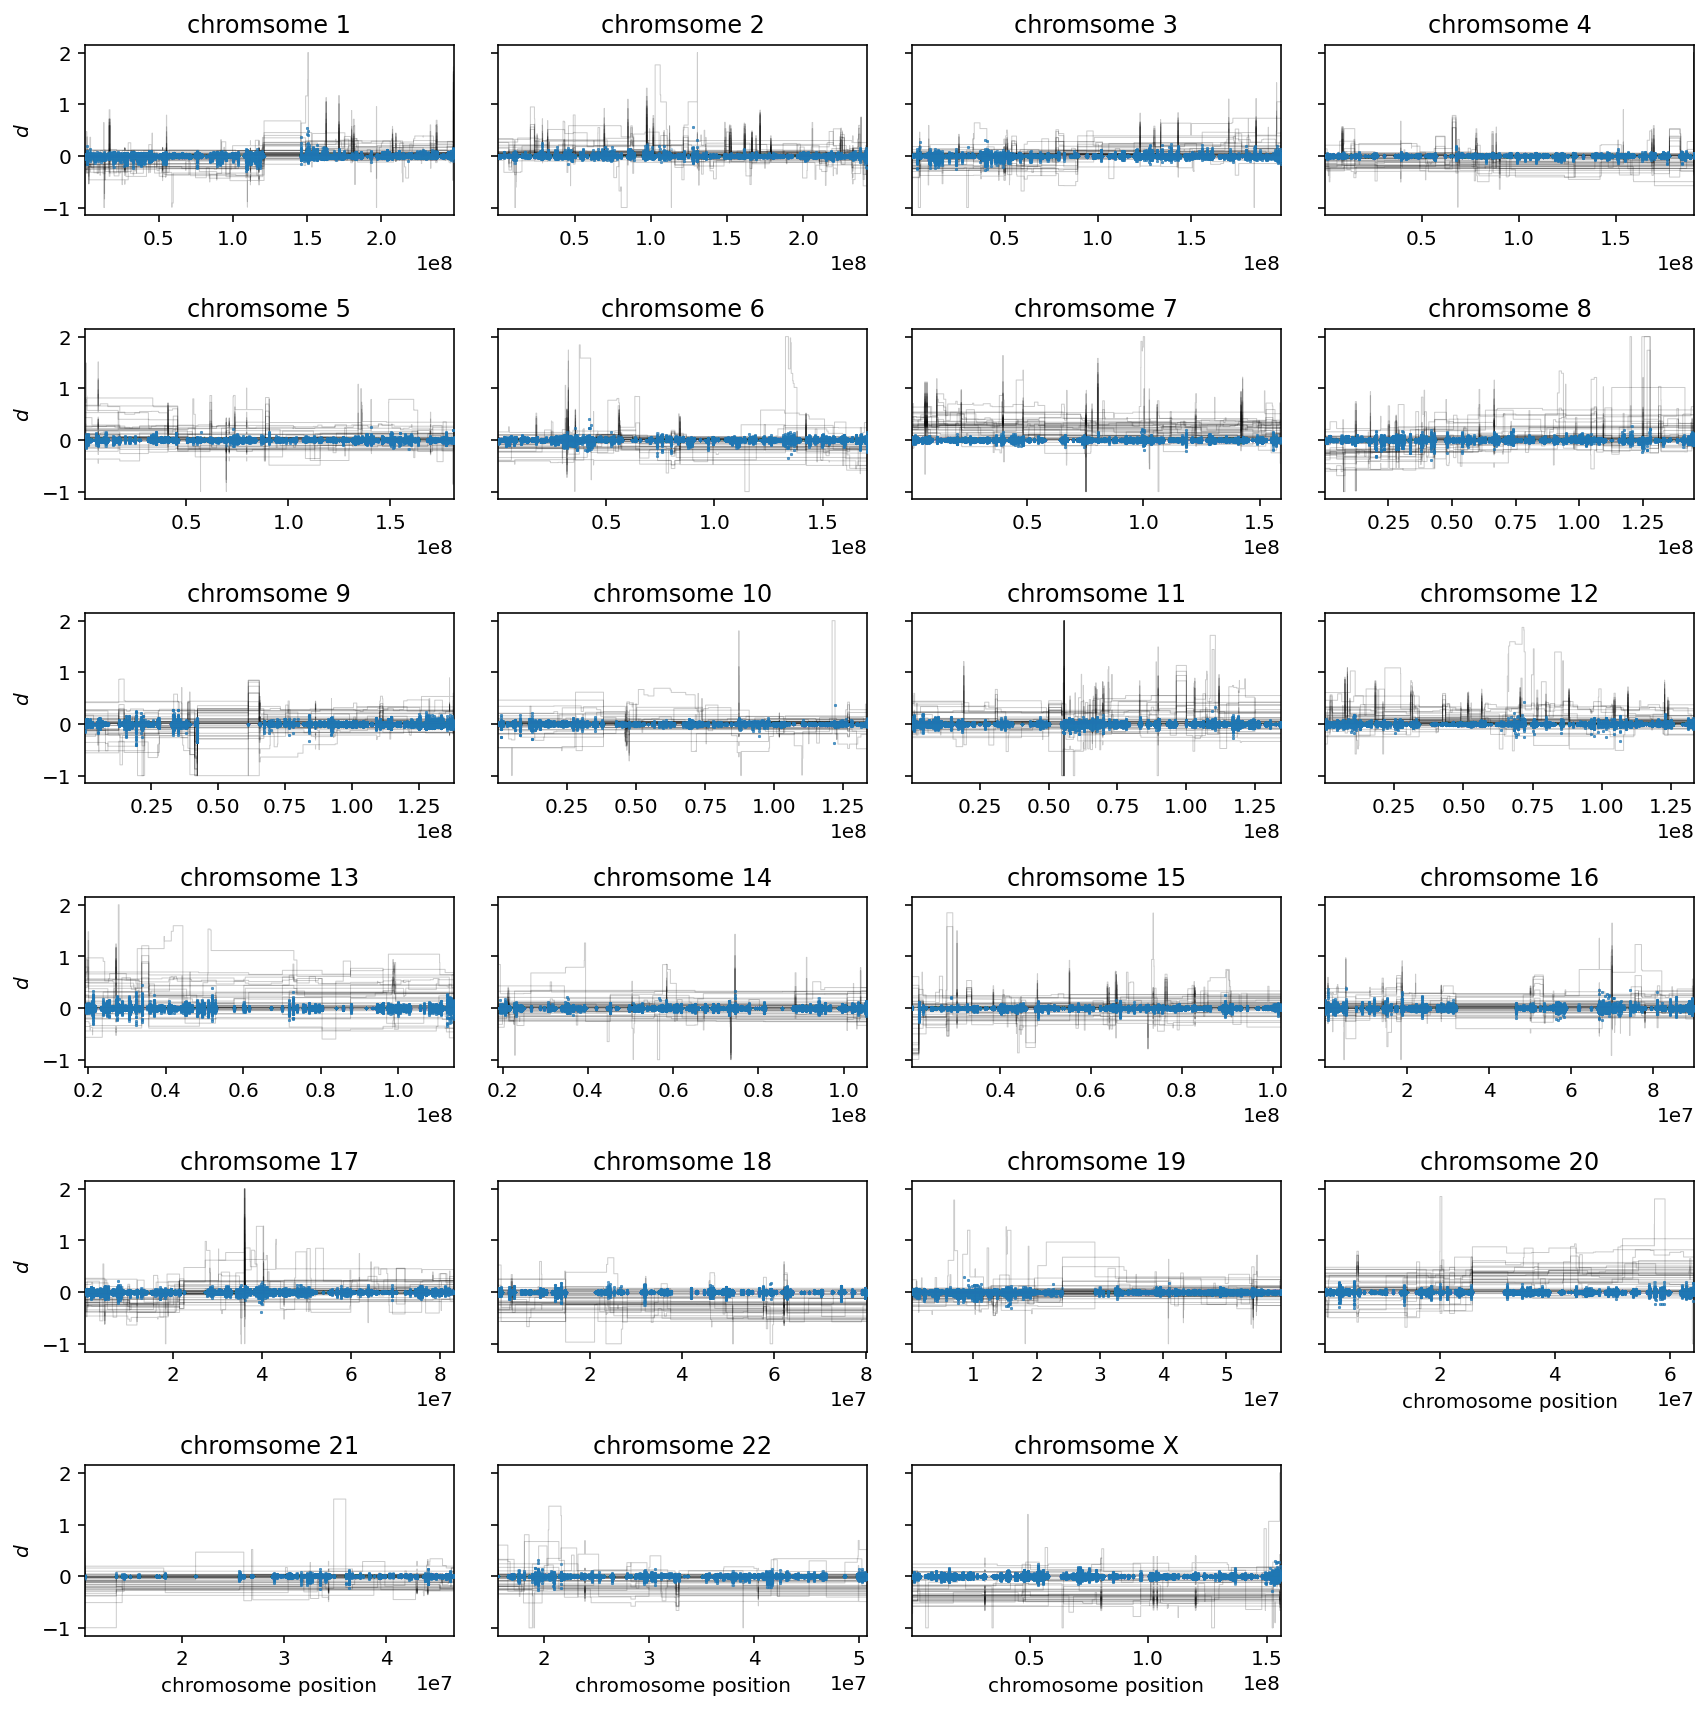

In [57]:
n_chroms = d_post["sgrna_target_chr"].nunique()
n_cols = 4
n_rows = ceil(n_chroms / n_cols)

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(n_cols * 3, n_rows * 2),
    sharex=False,
    sharey=True,
)

for ax, (chrom, data_c) in zip(axes.flatten(), d_post.groupby("sgrna_target_chr")):
    ax.set_title(f"chromsome {chrom}")

    # Plot CN for each cell line over the chromosome.
    cell_cn_data = (
        chrom_target_positions.copy()
        .query(f"sgrna_target_chr == '{chrom}'")
        .reset_index(drop=True)
        .assign(
            copy_number=lambda d: squish_array(d["copy_number"] - 1, lower=-1, upper=1)
        )
    )
    for _, data_cell in cell_cn_data.groupby("depmap_id"):
        sns.lineplot(
            data=data_cell,
            x="sgrna_target_pos",
            y="copy_number",
            alpha=0.2,
            lw=0.5,
            color="k",
            drawstyle="steps-pre",
            ax=ax,
            zorder=1,
        )

    # Plot the gene copy number effects over the chromosome.
    sns.scatterplot(
        data=data_c,
        x="sgrna_target_pos",
        y="cn_effect",
        ax=ax,
        color="tab:blue",
        s=2,
        alpha=0.3,
        edgecolor=None,
        zorder=5,
    )

    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(data_c["sgrna_target_pos"].min(), data_c["sgrna_target_pos"].max())
    # break

for ax in axes.flatten()[n_chroms:]:
    ax.axis("off")
for ax in axes[:, 0]:
    ax.set_ylabel("$d$")
for ax in axes.flatten()[(n_chroms - 4) : n_chroms]:
    ax.set_xlabel("chromosome position")

fig.tight_layout()
plt.show()

In [ ]:
def _plot_corr_heatmap(
    trace: az.InferenceData, corr_var_name: str, var_names: list[str]
) -> None:
    corr_post = (
        az.summary(trace, var_names=[corr_var_name], kind="stats")
        .pipe(extract_coords_param_names, names=["d1", "d2"])
        .astype({"d1": int, "d2": int})
        .assign(
            p1=lambda d: [var_names[i] for i in d["d1"]],
            p2=lambda d: [var_names[i] for i in d["d2"]],
        )
        .assign(
            p1=lambda d: pd.Categorical(
                d["p1"], categories=d["p1"].unique(), ordered=True
            )
        )
        .assign(
            p2=lambda d: pd.Categorical(
                d["p2"], categories=d["p1"].cat.categories, ordered=True
            )
        )
    )
    plot_df = corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
    ax = sns.heatmap(
        plot_df,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
    )
    ax.set_ylabel(None)
    plt.show()
    return None

In [ ]:
# TODO: change get from the trace when included in `posterior.coords`.
genes_var_names = postman.model_data_struct.coords["genes_params"]
_plot_corr_heatmap(postman.trace, "genes_chol_cov_corr", var_names=genes_var_names)

# TODO: change to use "cells_params" when that is included as a coord.
cells_var_names = postman.model_data_struct.coords["cells_params"]
_plot_corr_heatmap(postman.trace, "cells_chol_cov_corr", var_names=cells_var_names)

In [ ]:
if len(cancer_genes) > 1:
    cancer_gene_mutants = (
        postman.valid_data.filter_column_isin("hugo_symbol", cancer_genes)[
            ["hugo_symbol", "depmap_id", "is_mutated"]
        ]
        .drop_duplicates()
        .sort_values(["hugo_symbol", "depmap_id"])
        .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
        .set_index("depmap_id")
    )

    sns.clustermap(
        cancer_gene_mutants,
        cmap="gray_r",
        xticklabels=1,
        yticklabels=1,
        figsize=(3, 9),
        cbar_pos=(1, 0.4, 0.05, 0.2),
    )
    plt.show()

    sns.clustermap(
        cancer_gene_mutants.corr(),
        cmap="seismic",
        center=0,
        vmin=-1,
        vmax=1,
        figsize=(len(cancer_genes) * 0.5, len(cancer_genes) * 0.5),
    )
    plt.show()

In [ ]:
top_n = 5
top_b_hits = (
    postman.posterior_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_b = top_b_hits["hugo_symbol"][:top_n].values
positive_b = top_b_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_b, negative_b]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = postman.valid_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(
            data=obs_data, x="m_rna_gene", y="lfc", ax=ax, edgecolor=None, s=20
        )
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("log RNA expression")
fig.supylabel("log-fold change")

fig.tight_layout()
plt.show()

In [ ]:
top_n = 5
top_d_hits = (
    postman.posterior_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_d = top_d_hits["hugo_symbol"][:top_n].values
positive_d = top_d_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_d, negative_d]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = postman.valid_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="cn_gene", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("copy number")
fig.supylabel("log-fold change")
fig.tight_layout()
plt.show()

## Model predictions

In [ ]:
n_examples = 40
n_chains, n_draws, n_data = postman.trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = postman.trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = postman.trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(postman.valid_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")

x_max = 1000
x_cut = x_max * 5
for i in range(example_ppc_draws.shape[0]):
    x = example_ppc_draws[i, :]
    x = x[x < x_cut]
    sns.kdeplot(x=x, alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg[pp_avg < x_cut], color="tab:orange", ax=ax2)
_obs = postman.valid_data["counts_final"].values
_obs = _obs[_obs < x_cut]
sns.kdeplot(x=_obs, color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, x_max)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m